In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from nodepy import rk
from IPython.display import clear_output
import sys

ssp22 = rk.loadRKM('SSP22').__num__()
ssp22.bhat = np.array([1/3, 2/3])
#ssp22.bhat = np.array([1, 0])

ssp33 = rk.loadRKM('SSP33').__num__()
#ssp22.bhat = np.array([1/3, 2/3])
#print(ssp33.b)
print(ssp33.c)
ssp33.bhat= np.array([1., 0, 0])


A31= np.array([[0,0,0], [2/3,0,0], [1/3,1/3,0]])
b31= np.array([1/4, 0, 3/4])
rk31=  rk.ExplicitRungeKuttaMethod(A31,b31)
rk31.bhat= np.array([1/4, 3/8, 3/8])


# Third order Heun(3,3) method with a second order embedding
heun33 = rk.loadRKM('Heun33').__num__()
heun33.bhat = np.array([0.006419303047187, 0.487161393905626, 0.506419303047187]) # Main
#heun33.bhat = np.array([1, 0., 0])
#heun33.bhat = np.array([0.5, .5, 0.0]) 
#heun33.bhat = np.array([1/3,1/3,1/3])



# Fourth order classical RK(4,4) method with a second order embedding. 3rd order embedding is not possible
rk44 = rk.loadRKM('RK44').__num__()
rk44.bhat = np.array([0.25,0.25,0.25,0.25]) # Main
#rk44.bhat = np.array([1,0.,0.,0.0])
#rk44.bhat = np.array([0.5,0.5,0.,0.0])
#rk44.bhat = np.array([1/3,1/3,1/3,0.0])
#rk44.bhat = np.array([0,0,1.0])


fehlberg45 = rk.loadRKM("Fehlberg45").__num__()
fehlberg45.b = fehlberg45.bhat
fehlberg45.bhat = np.array([0.122702088570621, 0.000000000000003, 0.251243531398616, -0.072328563385151, 0.246714063515406, 0.451668879900505])
fehlberg45.b3 = np.array([0.150593325320835, 0.000000000000003, 0.275657325006399, 0.414789231909538, -0.131467847351019, 0.290427965114243])

# Fifth order DP(7,5) method with a fourth order embedding (bhat), which is already given and (A,b3) is also 
# 4th order accurate
dp75 = rk.loadRKM('DP5').__num__()
dp75.b3 = np.array([0.159422044716717, 0.000000000000009, 0.310936711045800, 0.444052776789396, 0.307005319740028, -0.230738637667449, 0.009321785375499]) #Main
print('dp75.c :',dp75.c)
print('dp75.bhat :',dp75.bhat)


print(ssp22.c)
print(ssp22.b)
rk44.c

[0.  1.  0.5]
dp75.c : [0.         0.2        0.3        0.8        0.88888889 1.
 1.        ]
dp75.bhat : [ 0.08991319  0.          0.45348907  0.6140625  -0.27151238  0.08904762
  0.025     ]
[0. 1.]
[0.5 0.5]


array([0. , 0.5, 0.5, 1. ])

In [24]:
colors = ['#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7', '#F0E442']
#linestyles = ['-', '--', '-.', ':', "-", "--", "-."]
linestyles = ['-', '--', '-.', ':', (5, (10, 3)),(0, (3, 1, 1, 1))]
markers = ['o','D','X','s','v',"P"]

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}

import matplotlib
matplotlib.rc('font', **font)

#plt.rc("text", usetex=True)
plt.rc("legend", fontsize="medium", fancybox=True, framealpha=0.5)

plt.rcParams["mathtext.fontset"] = "cm"

In [25]:
# Required functions for Euler's equation
def EulerEqs_f(u):
    u1 = u[0]; u2 = u[1]; u3 = u[2];
    alpha = 1 + 1/np.sqrt(1.51); beta = 1 - 0.51/np.sqrt(1.51)
    du1 = (alpha - beta)*u2*u3
    du2 = (1 - alpha)*u3*u1
    du3 = (beta - 1)*u1*u2
    return np.array([du1, du2, du3])

def G_1(u):
    u1 = u[0]; u2 = u[1]; u3 = u[2];
    return u1*u1 + u2*u2 + u3*u3

def dG_1(u):
    return np.array([ 2*u[0], 2*u[1], 2*u[2] ])



def G_2(u):
    u1 = u[0]; u2 = u[1]; u3 = u[2];
    alpha = 1 + 1/np.sqrt(1.51); beta = 1 - 0.51/np.sqrt(1.51)
    return u1*u1 + beta*u2*u2 + alpha*u3*u3

def dG_2(u):
    alpha = 1 + 1/np.sqrt(1.51); beta = 1 - 0.51/np.sqrt(1.51)
    return np.array([2*u[0], 2*beta*u[1], 2*alpha*u[2]])
    


def rgam(gammas,u,inc1,inc2,E1_old,E2_old):
    gamma1, gamma2 = gammas
    uprop = u + gamma1*inc1 + gamma2*inc2  
    E1 = G_1(uprop)
    E2 = G_2(uprop)
    return np.array([E1-E1_old,E2-E2_old])

def rgam_RF(epss,dt, u_tilde, search1,search2,E1_old,E2_old):
    eps1, eps2 = epss
    
    uprop = u_tilde + dt* eps1* search1  + dt* eps2* search2
    E1 = G_1(uprop)
    E2 = G_2(uprop)
    return np.array([E1-E1_old,E2-E2_old])



from scipy import special
def EulerEqs_ExactSol(t):
    sn, cn, dn, ph = special.ellipj(t, 0.51) 
    u1 = np.sqrt(1.51)*sn
    u2 = cn
    u3 = dn
    return np.array([u1, u2, u3])

In [26]:
def project_direction(v1, v2, F):
    s= np.size(F[:, 0])
    n= np.size(F[0, :])

    Normals= np.zeros((1, n))

    v1= v1/ np.linalg.norm(v1)
    v2= v2/ np.linalg.norm(v2)




    for i in range(s):
        normal = np.copy(F[i , :]).copy()
        normal= normal/ np.linalg.norm(normal)
        for j in range(np.size( Normals[:, 0] )):

            normal -= np.dot(normal, Normals[j, :])* Normals[j, :]

        
        
        if np.linalg.norm(normal) > 1.e-9:
            normal= normal / np.linalg.norm(normal)

            Normals= np.append(Normals, np.reshape(normal.copy(), (1,len(normal))), axis=0)
            

    
    v1_projected= np.zeros(n)
    v2_projected= np.zeros(n)
    
    for i in range(np.size( Normals[:, 0] )):
        #print('dot(u, Normals): ',np.dot(u, Normals[i, :]))
        v1_projected += np.dot(v1, Normals[i, :])* Normals[i, :]
        v2_projected += np.dot(v2, Normals[i, :])* Normals[i, :]


    return v1_projected, v2_projected

# Baseline RK

In [27]:
# Compute solution with baseline RK methods
def compute_sol_without_relaxation(Mthdname,rkm, dt, f, T, u0,t0): 
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    Inv1= np.array(G_1(u0)); Inv2= np.array(G_2(u0));
    
    steps = 0
    
    while t < T and not np.isclose(t, T):
        clear_output(wait=True)
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = uu[-1].copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])
        inc = dt*sum([rkm.b[i]*F[i] for i in range(s)])    
        unew = uu[-1]+inc; t+= dt

        E1_new= G_1(unew)
        E2_new= G_2(unew)
        Inv1= np.append(Inv1, E1_new) ; Inv2= np.append(Inv2, E2_new)
        
        
        tt = np.append(tt, t)
        steps +=1
        uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0)  
        print("Method = Baseline %s: Step number = %d (time = %1.2f)"%(Mthdname,steps,tt[-1]))
    return tt, uu, Inv1, Inv2

# MRRK 

In [28]:
# Computing solution with multiple relaxation methods
def compute_sol_multi_relaxation(Mthdname,rkm, dt, f, T, u0, t0):
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    
    G1 = np.array([]); G2 = np.array([])
    no_inv = 2; gammas0 = np.zeros(no_inv)
    Inv1= np.array(G_1(u0)); Inv2= np.array(G_2(u0));
    
    errs = 0; steps = 0
    
    while t < T and not np.isclose(t, T):
        clear_output(wait=True)
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = uu[-1].copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])
            
        inc1 = dt*sum([rkm.b[i]*F[i] for i in range(s)])
        inc2 = dt*sum([rkm.bhat[i]*F[i] for i in range(s)])
        
        #wr_unew = uu[-1] + inc1; E1_old = G_1(uu[-1]); E2_old = G_2(uu[-1])
        wr_unew = uu[-1] + inc1; E1_old = G_1(uu[0]); E2_old = G_2(uu[0])
        
        gammas, info, ier, mesg = fsolve(rgam,gammas0,args=(wr_unew,inc1,inc2,E1_old,E2_old),full_output=True)
        gamma1, gamma2 = gammas
        #print('gammas: ', gammas)
        
        unew =  wr_unew + gamma1*inc1 + gamma2*inc2;
        
        t+=(1+gamma1+gamma2)*dt
        #t+=dt
        
        E1_new= G_1(unew)
        E2_new= G_2(unew)
       
        if np.abs(E1_new- E1_old)> 1.e-13 or np.abs(E2_new- E2_old)> 1.e-13 :
            
            print('Error_ Relaxation Method: Invariant(s) are not preserved  ')
            print('dt: ', dt)
            print('t: ', t)
            
            sys.exit(1)
            
        
        tt = np.append(tt, t)
        steps += 1
        uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0) 
        G1 = np.append(G1, gamma1); G2 = np.append(G2, gamma2)

        Inv1= np.append(Inv1, E1_new) ; Inv2= np.append(Inv2, E2_new)
        
        #print("Method = Relaxation %s: At step number = %d (time = %1.2f), integer flag = %d and E1-E1_old = %f, E2-E2_old = %f \n"%(Mthdname,steps,tt[-1],ier,E1_new-E1_old,E2_new-E2_old))

    ave_dt= dt* (1+ np.average(G1) + np.average(G2))

    return tt, uu, ave_dt, G1, G2, Inv1, Inv2

# Multiple QO

In [29]:
def compute_sol_multi_QO(Mthdname,rkm, dt, f, T, u0, t0):
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    u = np.array(u0)
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    b= rkm.b

    #old_eps= 0.001 # To be determined
    
    Eps1 = np.array([]); Eps2 = np.array([])
    Inv1= np.array(G_1(u0)); Inv2= np.array(G_2(u0)); 
    
    no_inv = 2; epss0 = np.zeros(no_inv)
    
    errs = 0; steps = 0
    n=0
    
    while t < T and not np.isclose(t, T):
    #while t < T and not n > 1 and not np.isclose(t, T):

        n+=1 
        clear_output(wait=True)
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = u.copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])

  


        
        u_tilde= u + dt*sum([b[i]*F[i] for i in range(s)])
        #print(u_tilde/np.linalg.norm(u_tilde))

        dG1= dG_1(u_tilde) / np.linalg.norm(dG_1(u_tilde))
        dG2= dG_2(u_tilde) / np.linalg.norm(dG_2(u_tilde))

 
        


        search1, search2 = project_direction (dG_1(u_tilde), dG_2(u_tilde), F) # projects dG_1(wr_unew) to the space created by stage derivative vectors
        if np.linalg.norm(search1) < 1.e-7 or np.linalg.norm(search2) < 1.e-7:
            print('Search close to zero')


        search1= search1 /np.linalg.norm(search1)
        search2= search2 /np.linalg.norm(search2)



        #rgam_RF(epss,dt, u_tilde, search1,search2, E1_old,E2_old)
        
        
        E1_old = G_1(u); E2_old = G_2(u)
       
        epss, info, ier, mesg = fsolve(rgam_RF,epss0,args=(dt, u_tilde,search1, search2,E1_old,E2_old),full_output=True)
        
        eps1, eps2 = epss
      
        
        u = u_tilde + dt*eps1*search1 + dt*eps2*search2; 
        #u= u_tilde
        t+=dt



        E1_new= G_1(u)
        E2_new= G_2(u)
        tt = np.append(tt, t)
        steps += 1
        uu = np.append(uu, np.reshape(u.copy(), (1,len(u))), axis=0) 
        Eps1 = np.append(Eps1, eps1); Eps2 = np.append(Eps2, eps2)
        Inv1= np.append(Inv1, E1_new) ; Inv2= np.append(Inv2, E2_new)
        #print("Method = RF %s: At step number = %d (time = %1.2f), integer flag = %d and E1-E1_old = %f, E2-E2_old = %f \n"%(Mthdname,steps,tt[-1],ier,E1_new-E1_old,E2_new-E2_old))

    return tt, uu, Eps1, Eps2, Inv1, Inv2

# Directional method

In [31]:
def compute_sol_multi_D(Mthdname,rkm, dt, f, T, u0, t0):
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    u = np.array(u0)
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    b= rkm.b

    
    Eps1 = np.array([]); Eps2 = np.array([])
    Inv1_change= np.array([]); Inv2_change= np.array([]); 
    
    no_inv = 2; epss0 = np.zeros(no_inv)
    
    errs = 0; steps = 0
    n=0
    
    while t < T and not np.isclose(t, T):
    #while t < T and not n > 1 and not np.isclose(t, T):

        n+=1 
        clear_output(wait=True)
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = u.copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])

  



        
        u_tilde= u + dt*sum([b[i]*F[i] for i in range(s)])
        #print(u_tilde/np.linalg.norm(u_tilde))

        dG1= dG_1(u_tilde) / np.linalg.norm(dG_1(u_tilde))
        dG2= dG_2(u_tilde) / np.linalg.norm(dG_2(u_tilde))

        #print('dG1= ', dG1)
        #print('dG2= ', dG2)
        search1= sum([rkm.b[i]*F[i] for i in range(s)]) - F[0]
        search2= sum([rkm.b[i]*F[i] for i in range(s)]) - sum([rkm.bhat[i]*F[i] for i in range(s)])
        


        search1= search1 /np.linalg.norm(search1)
        search2= search2 /np.linalg.norm(search2)

        
        
        
        E1_old = G_1(u); E2_old = G_2(u)
    
        epss, info, ier, mesg = fsolve(rgam_RF,epss0,args=(dt, u_tilde,search1, search2,E1_old,E2_old),full_output=True)
        
        eps1, eps2 = epss
        
        
        u = u_tilde + dt*eps1*search1 + dt*eps2*search2; 
        #u= u_tilde
        t+=dt
        

        

        E1_new= G_1(u)
        E2_new= G_2(u)
        tt = np.append(tt, t)

        if np.abs(E1_new- E1_old)> 1.e-13 or np.abs(E2_new- E2_old)> 1.e-13 :
            
            print('Error_ Relaxation Method: Invariant(s) are not preserved  ')
            print('dt: ', dt)
            print('t: ', t)
            
            sys.exit(1)
       


        
        steps += 1
        uu = np.append(uu, np.reshape(u.copy(), (1,len(u))), axis=0) 
        Eps1 = np.append(Eps1, eps1); Eps2 = np.append(Eps2, eps2)
        Inv1_change= np.append(Inv1_change, E1_new-E1_old) ; Inv2_change= np.append(Inv2_change, E2_new-E2_old)
        #print("Method = RF %s: At step number = %d (time = %1.2f), integer flag = %d and E1-E1_old = %f, E2-E2_old = %f \n"%(Mthdname,steps,tt[-1],ier,E1_new-E1_old,E2_new-E2_old))

    return tt, uu, Eps1, Eps2, Inv1_change, Inv2_change

# Convergence QO_RK

In [32]:
methods = [heun33,rk44,dp75]

method_names = ['Heun(3,3)','RK(4,4)','DP(7,5)']
dts = 1/2**np.linspace(3,8,10)
dts = dts[0:]
f = EulerEqs_f; tf = 5
# Initial condition
t0 = 0; u0 = np.array([0.0, 1.0, 1.0])
qo_errs = np.zeros((len(methods),len(dts))); r_errs = np.zeros((len(methods),len(dts)));  rf_errs = np.zeros((len(methods),len(dts)))

for idx in range(len(methods)):
    rkm = methods[idx]
    for dt_idx in range(len(dts)):
        dt = dts[dt_idx]

        rf_T, rf_U, Eps1, Eps2, Inv1_change, Inv2_change= compute_sol_multi_QO(method_names[idx], rkm, dt, f, tf, u0, t0)
        
        
    
        qo_error = np.max(np.abs(rf_U[-1, :]-EulerEqs_ExactSol(rf_T[-1]))); 
        
      
        qo_errs[idx][dt_idx]=qo_error;

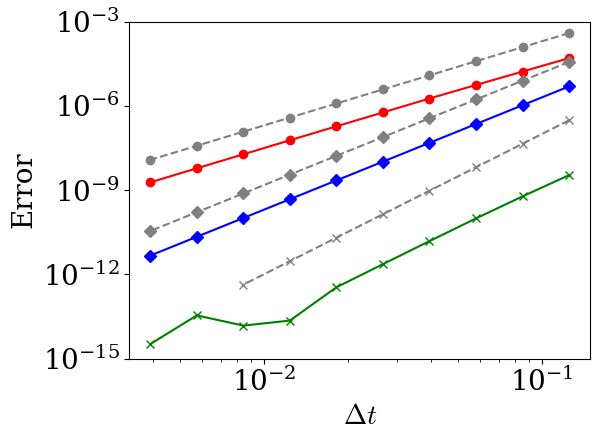

<Figure size 640x480 with 0 Axes>

In [33]:
from itertools import cycle
lines = [":","--","-.","-"]

markers = ['o','D','x','s','v',"P"]


colors = ["red", "blue", "green" ,"darkviolet"]






fig = plt.figure(2)
for idx in range(len(methods)):
    
    plt.plot(dts,qo_errs[idx],color = colors[idx],linestyle='-', marker= markers[idx],label = method_names[idx])

plt.ylim(1.e-15, 1.e-3)

plt.plot(dts, 2.0e-1*dts**3,'--',marker= markers[0], color="gray", label= '$\mathcal{O}(\Delta t^3)$')
plt.plot(dts, 1.5e-1*dts**4,'--',marker= markers[1], color="gray", label= '$\mathcal{O}(\Delta t^4)$')
plt.plot(dts[:8], 1e-2*dts[:8]**5, '--',marker= markers[2], color="gray", label= '$\mathcal{O}(\Delta t^5)$')
plt.xscale("log"); plt.yscale("log"); plt.xlabel("$\Delta t$"); plt.ylabel('Error')
fig.tight_layout()

#plt.savefig("./Figures/RBR_convergence_QO.png",bbox_inches="tight")

ax = plt.gca()
plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=6)

#plt.savefig("./Figures/RBR_convergence_legend.png",bbox_inches="tight")


plt.show()

# Convergence RRK, Original embedded methods

In [34]:


heun33 = rk.loadRKM('Heun33').__num__()
heun33.bhat = np.array([0.006419303047187, 0.487161393905626, 0.506419303047187]) # Main

rk44 = rk.loadRKM('RK44').__num__()
rk44.bhat = np.array([0.25,0.25,0.25,0.25]) # Main
dp75 = rk.loadRKM('DP5').__num__()



methods = [heun33,rk44,dp75]


method_names = ['Heun(3,3)','RK(4,4)','DP(7,5)']
dts = 1/2**np.linspace(3,8,10)
dts = dts[0:]
dts_actual= np.zeros((len(methods),len(dts)))
ave_gammas= np.zeros((len(methods),len(dts)))

f = EulerEqs_f; tf = 5
# Initial condition
t0 = 0; u0 = np.array([0.0, 1.0, 1.0])
b_errs = np.zeros((len(methods),len(dts))); r_errs = np.zeros((len(methods),len(dts)));  rf_errs = np.zeros((len(methods),len(dts)))

for idx in range(len(methods)):
    rkm = methods[idx]
    for dt_idx in range(len(dts)):
        dt = dts[dt_idx]
        r_T, r_U, ave_dt, G1, G2, Inv1_change, Inv2_change = compute_sol_multi_relaxation(method_names[idx], rkm, dt, f, tf, u0, t0)
        dts_actual[idx][dt_idx]=(1+ np.average(G1)+ np.average(G2))*dt
        ave_gammas[idx][dt_idx]= np.average(G1)+ np.average(G2)
        
        r_error = np.max(np.abs(r_U[-1]-EulerEqs_ExactSol(r_T[-1]))); 
        
        r_errs[idx][dt_idx]=r_error; 


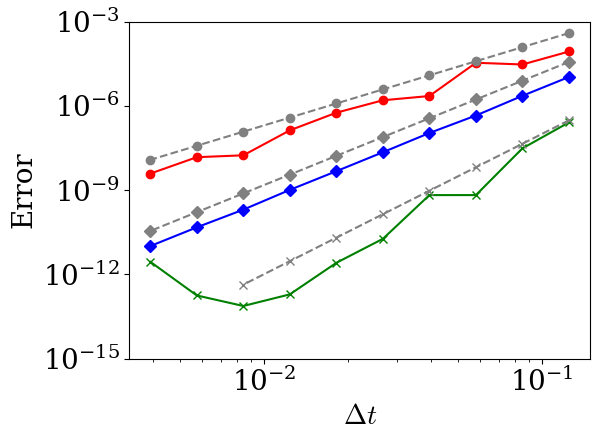

In [35]:


#--------------------------------------------------------------------------------------

from itertools import cycle
lines = [":","--","-.","-"]

markers = ['o','D','x','s','v',"P"]


colors = ["red", "blue", "green" ,"darkviolet"]






fig = plt.figure(2)
for idx in range(len(methods)):
   
    plt.plot(dts_actual[idx],r_errs[idx],color = colors[idx],linestyle='-', marker= markers[idx],label = method_names[idx])

plt.ylim(1.e-15, 1.e-3)

plt.plot(dts, 2.0e-1*dts**3,'--',marker= markers[0], color="gray", label= '$\Delta t^3$')
#plt.annotate( (2.0e-2, 1.0e-5), color="gray", fontsize=12, label= '$\Delta t^3$')
plt.plot(dts, 1.5e-1*dts**4,'--',marker= markers[1], color="gray", label= '$\Delta t^4$')
#plt.annotate( (2.0e-2, 8.0e-8), color="gray", fontsize=12, label= '$\Delta t^4$')
plt.plot(dts[:8], 1e-2*dts[:8]**5, '--',marker= markers[2], color="gray", label= '$\Delta t^5$')
#plt.annotate( (2.0e-2, 2.0e-10), color="gray", fontsize=12, label= '$\Delta t^5$')
plt.xscale("log"); plt.yscale("log"); plt.xlabel("$\Delta t$"); plt.ylabel('Error')
fig.tight_layout()
#plt.legend(fontsize=12)

#plt.savefig("./Figures/RBR_convergence_RRK.png",bbox_inches="tight")




plt.show()

# Relaxation, Alternative embedded methods

In [36]:


rk44 = rk.loadRKM('RK44').__num__()
 
rk44.bhat = np.array([1/3, 1/3,1/3 ,0.]) 





methods = [rk44]


method_names = ['RK(4,4)']


dts= [0.01]

dts_actual= np.zeros((len(methods),len(dts)))
ave_gammas= np.zeros((len(methods),len(dts)))

f = EulerEqs_f; tf = 5
# Initial condition
t0 = 0; u0 = np.array([0.0, 1.0, 1.0])
b_errs = np.zeros((len(methods),len(dts))); r_errs = np.zeros((len(methods),len(dts)));  rf_errs = np.zeros((len(methods),len(dts)))

for idx in range(len(methods)):
    rkm = methods[idx]
    for dt_idx in range(len(dts)):
        dt = dts[dt_idx]
        r_T, r_U, ave_dt, G1, G2, Inv1_change, Inv2_change = compute_sol_multi_relaxation(method_names[idx], rkm, dt, f, tf, u0, t0)
        dts_actual[idx][dt_idx]=(1+ np.average(G1)+ np.average(G2))*dt
        ave_gammas[idx][dt_idx]= np.average(G1)+ np.average(G2)
        
        r_error = np.max(np.abs(r_U[-1]-EulerEqs_ExactSol(r_T[-1]))); 
        
        r_errs[idx][dt_idx]=r_error; 


Error_ Relaxation Method: Invariant(s) are not preserved  
dt:  0.01
t:  3.7499791299723477


SystemExit: 1

# Directional method, alternative embedded methods

In [37]:


rk44 = rk.loadRKM('RK44').__num__()
#rk44.bhat = np.array([0.25,0.25,0.25,0.25]) # Main
rk44.bhat = np.array([0., 0,1 ,0.]) 





methods = [ rk44]


method_names = ['RK(4,4)']

dts = 1/2**np.linspace(3,8,10)


dts_actual= np.zeros((len(methods),len(dts)))
ave_gammas= np.zeros((len(methods),len(dts)))

f = EulerEqs_f; tf = 5
# Initial condition
t0 = 0; u0 = np.array([0.0, 1.0, 1.0])
b_errs = np.zeros((len(methods),len(dts))); r_errs = np.zeros((len(methods),len(dts)));  d_errs = np.zeros((len(methods),len(dts)))

for idx in range(len(methods)):
    rkm = methods[idx]
    for dt_idx in range(len(dts)):
        dt = dts[dt_idx]
        
        d_T, d_U, Eps1, Eps2, Inv1_change, Inv2_change= compute_sol_multi_D(method_names[idx], rkm, dt, f, tf, u0, t0)
        
        
       
        d_error = np.max(np.abs(d_U[-1, :]-EulerEqs_ExactSol(d_T[-1]))); 
        

        d_errs[idx][dt_idx]=d_error;

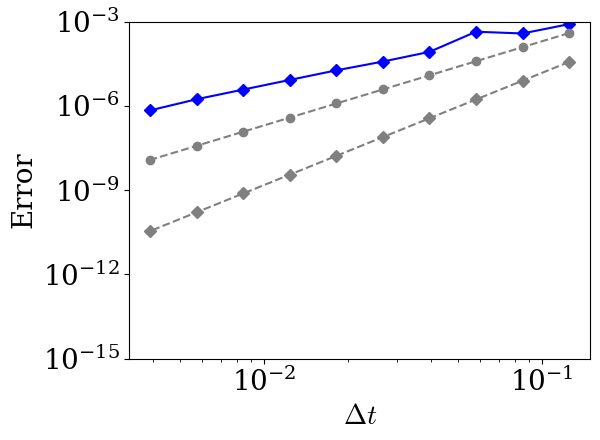

<Figure size 640x480 with 0 Axes>

In [38]:
from itertools import cycle
lines = [":","--","-.","-"]

markers = ['o','D','x','s','v',"P"]


colors = ["blue", "green" ,"darkviolet"]






fig = plt.figure(2)
for idx in range(len(methods)):
   
    plt.plot(dts,d_errs[idx],color = colors[idx],linestyle='-',marker= markers[idx+1],label = method_names[idx])


plt.ylim(1.e-15, 1.e-3)

plt.plot(dts, 2.0e-1*dts**3,'--',marker= markers[0], color="gray", label= '$\mathcal{O}(\Delta t^3)$')
plt.plot(dts, 1.5e-1*dts**4,'--',marker= markers[1], color="gray", label= '$\mathcal{O}(\Delta t^4)$')


plt.xscale("log"); plt.yscale("log"); plt.xlabel("$\Delta t$"); plt.ylabel('Error')
fig.tight_layout()

#plt.savefig("./Figures/RBR_alter_convergence_RF.png",bbox_inches="tight")

ax = plt.gca()
plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=3)

#plt.savefig("./Figures/RBR_alter_convergence_RF_legend.png",bbox_inches="tight")


plt.show()

# Convergence Directional

In [39]:
heun33 = rk.loadRKM('Heun33').__num__()
heun33.bhat = np.array([0.006419303047187, 0.487161393905626, 0.506419303047187]) # Main

rk44 = rk.loadRKM('RK44').__num__()
rk44.bhat = np.array([0.25,0.25,0.25,0.25]) # Main
dp75 = rk.loadRKM('DP5').__num__()



methods = [heun33,rk44,dp75]
#methods = [ ssp22]
#method_names = ["ssp22"]
method_names = ['Heun(3,3)','RK(4,4)','DP(7,5)']


dts = 1/2**np.linspace(3,8,10)
dts = dts[0:]
f = EulerEqs_f; tf = 5
# Initial condition
t0 = 0; u0 = np.array([0.0, 1.0, 1.0])
b_errs = np.zeros((len(methods),len(dts))); r_errs = np.zeros((len(methods),len(dts)));  d_errs = np.zeros((len(methods),len(dts)))

for idx in range(len(methods)):
    rkm = methods[idx]
    for dt_idx in range(len(dts)):
        dt = dts[dt_idx]
       
        d_T, d_U, Eps1, Eps2, Inv1_change, Inv2_change= compute_sol_multi_D(method_names[idx], rkm, dt, f, tf, u0, t0)
        
        
       
        d_error = np.max(np.abs(d_U[-1, :]-EulerEqs_ExactSol(d_T[-1]))); 
        
       
        d_errs[idx][dt_idx]=d_error;

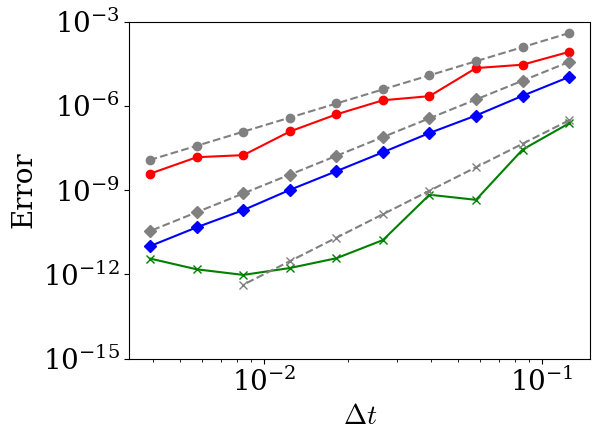

<Figure size 640x480 with 0 Axes>

In [40]:
from itertools import cycle
lines = [":","--","-.","-"]

markers = ['o','D','x','s','v',"P"]


colors = ["red", "blue", "green" ,"darkviolet"]






fig = plt.figure(2)
for idx in range(len(methods)):
    
    plt.plot(dts,d_errs[idx],color = colors[idx],linestyle='-',marker= markers[idx],label = method_names[idx])


plt.ylim(1.e-15, 1.e-3)

plt.plot(dts, 2.0e-1*dts**3, '--',marker= markers[0], color="gray")
plt.plot(dts, 1.5e-1*dts**4, '--',marker= markers[1], color="gray")
plt.plot(dts[:8], 1e-2*dts[:8]**5, '--',marker= markers[2], color="gray")

plt.xscale("log"); plt.yscale("log"); plt.xlabel("$\Delta t$"); plt.ylabel('Error')
fig.tight_layout()


#plt.savefig("./Figures/RBR_convergence_RF.png",bbox_inches="tight")

ax = plt.gca()
plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=4)

#plt.savefig("./Figures/RBR_convergence_legend.png",bbox_inches="tight")


plt.show()

# Change in invariant QO_RK - Heun(3,3)

Method = Baseline Heun(3,3): Step number = 5000 (time = 200.00)


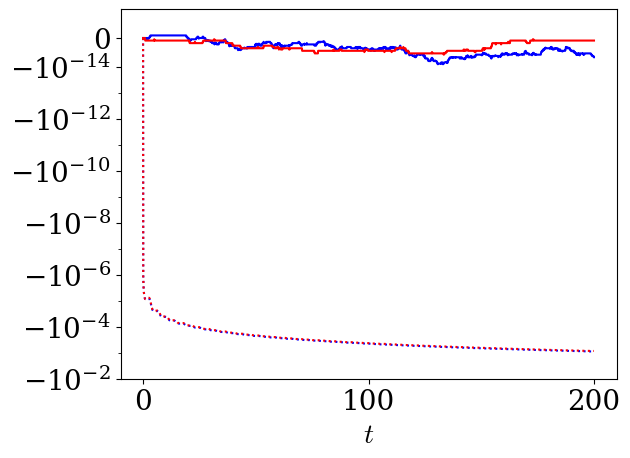

<Figure size 640x480 with 0 Axes>

In [41]:
dt= 0.04

tf= 200
method= heun33
Mthdname= 'Heun(3,3)'

f = EulerEqs_f; 
# Initial condition
t0 = 0; u0 = np.array([0.0, 1.0, 1.0])



tt, uu, Eps1, Eps2, Inv1_qo, Inv2_qo= compute_sol_multi_QO(Mthdname, method, dt, f, tf, u0, t0=0)

tt, uu, Inv1, Inv2= compute_sol_without_relaxation(Mthdname,method, dt, f, tf, u0,t0=0)

plt.figure()
plt.plot(tt, Inv1_qo- Inv1_qo[0], 'b',  label= 'Quasi-Orthogonal: $G_1(q(t))- G_1(q(0))$' )
plt.plot(tt, Inv2_qo- Inv2_qo[0] , 'r', label= 'Quasi-Orthogonal: $G_2(q(t))- G_2(q(0))$'  )

plt.plot(tt, Inv1- Inv1[0], 'b:',  label= 'Base RK: $G_1(q(t))- G_1(q(0))$'  )
plt.plot(tt, Inv2- Inv2[0] , 'r:', label= 'Base RK: $G_2(q(t))- G_2(q(0))$')

plt.ylim(-0.01, 1.e-14)


plt.yscale("symlog", linthresh=1.e-14)

plt.yticks([  -1.e-2, -1.e-4, -1.e-6, -1.e-8, -1.e-10,- 1.e-12 ,-1.e-14, 0 ])
plt.xticks([0, 100, 200])

plt.xlabel("$ t$")

#plt.savefig("Figures/RBR_Heun.png",bbox_inches="tight")

ax = plt.gca()
plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=2)
#plt.savefig("./Figures/RBR_evol_legend.png",bbox_inches="tight")


plt.show()  



# RK44

Method = Baseline RK(4,4): Step number = 2000 (time = 200.00)


Text(0.5, 0, '$ t$')

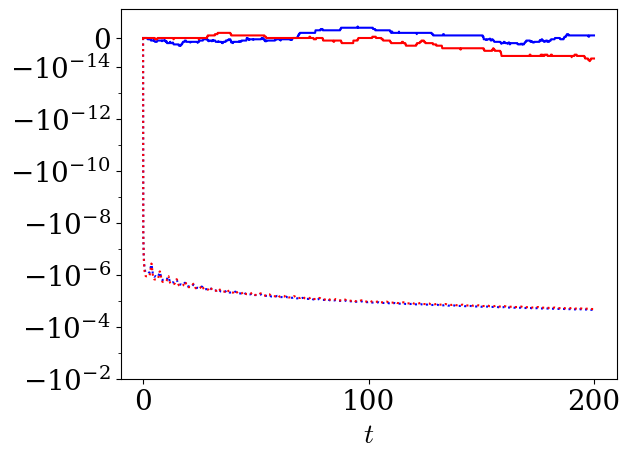

In [42]:
dt= 0.1

tf= 200
method= rk44
Mthdname= 'RK(4,4)'

f = EulerEqs_f; 
# Initial condition
t0 = 0; u0 = np.array([0.0, 1.0, 1.0])



tt, uu, Eps1, Eps2, Inv1_qo, Inv2_qo= compute_sol_multi_QO(Mthdname, method, dt, f, tf, u0, t0=0)

tt, uu, Inv1, Inv2= compute_sol_without_relaxation(Mthdname,method, dt, f, tf, u0,t0=0)

plt.figure()
plt.plot(tt, Inv1_qo- Inv1_qo[0], 'b',  label= 'Qusi_Orthogoanal: $G_1(u_1(t), u_2(t), u_3(t))- G_1(u_1(0), u_2(0), u_3(0))$' )
plt.plot(tt, Inv2_qo- Inv2_qo[0] , 'r', label= 'Qusi_Orthogoanal: $G_2(u_1(t), u_2(t), u_3(t))- G_2(u_1(0), u_2(0), u_3(0))$'  )

plt.plot(tt, Inv1- Inv1[0], 'b:',  label= 'Base RK: $G_1(u_1(t), u_2(t), u_3(t))- G_1(u_1(0), u_2(0), u_3(0))$' )
plt.plot(tt, Inv2- Inv2[0] , 'r:', label= 'Base RK: $G_2(u_1(t), u_2(t), u_3(t))- G_2(u_1(0), u_2(0), u_3(0))$')

plt.ylim(-0.01, 1.e-14)
plt.yscale("symlog", linthresh=1.e-14)

plt.yticks([  -1.e-2, -1.e-4, -1.e-6, -1.e-8, -1.e-10,- 1.e-12 ,-1.e-14, 0 ])
plt.xticks([0, 100, 200])

plt.xlabel("$ t$")

#plt.savefig("Figures/RBR_RK44.png",bbox_inches="tight")


# DP(7,5)

Method = Baseline DP(7,5): Step number = 2000 (time = 200.00)


Text(0.5, 0, '$ t$')

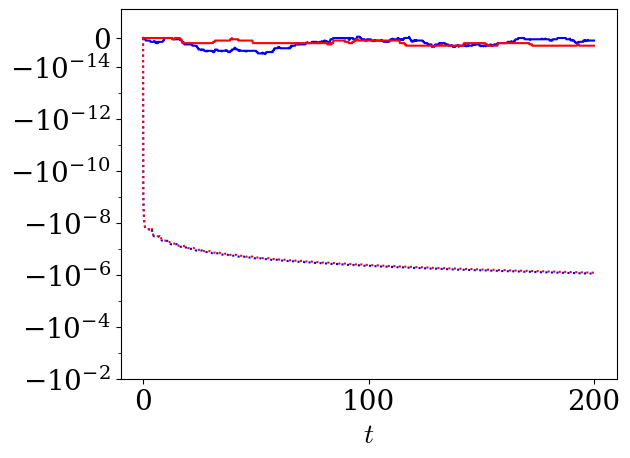

In [43]:
dt= 0.1

tf= 200
method= dp75
Mthdname= 'DP(7,5)'

f = EulerEqs_f; 
# Initial condition
t0 = 0; u0 = np.array([0.0, 1.0, 1.0])



tt, uu, Eps1, Eps2, Inv1_qo, Inv2_qo= compute_sol_multi_QO(Mthdname, method, dt, f, tf, u0, t0=0)

tt, uu, Inv1, Inv2= compute_sol_without_relaxation(Mthdname,method, dt, f, tf, u0,t0=0)

plt.figure()
plt.plot(tt, Inv1_qo- Inv1_qo[0], 'b',  label= 'Qusi_Orthogoanal: $G_1(u_1(t), u_2(t), u_3(t))- G_1(u_1(0), u_2(0), u_3(0))$'  )
plt.plot(tt, Inv2_qo- Inv2_qo[0] , 'r', label= 'Qusi_Orthogoanal: $G_2(u_1(t), u_2(t), u_3(t))- G_2(u_1(0), u_2(0), u_3(0))$' )

plt.plot(tt, Inv1- Inv1[0], 'b:',  label= 'Base RK: $G_1(u_1(t), u_2(t), u_3(t))- G_1(u_1(0), u_2(0), u_3(0))$' )
plt.plot(tt, Inv2- Inv2[0] , 'r:', label= 'Base RK: $G_2(u_1(t), u_2(t), u_3(t))- G_2(u_1(0), u_2(0), u_3(0))$')

plt.ylim(-0.01, 1.e-14)
plt.yscale("symlog", linthresh=1.e-14)

plt.yticks([  -1.e-2, -1.e-4, -1.e-6, -1.e-8, -1.e-10,- 1.e-12 ,-1.e-14, 0 ])
plt.xticks([0, 100, 200])

plt.xlabel("$ t$")

#plt.savefig("Figures/RBR_dp75.png",bbox_inches="tight")
